In [27]:
import pandas as pd
import numpy as np
%matplotlib inline

In [28]:
test_data = pd.read_pickle('dataset/testData.pkl')
test_data.head()

,ID,Captions
0,6735,"[4, 12, 3, 16, 1, 5, 791, 2, 3, 78, 59, 5427, ..."
1,6740,"[4, 1, 5, 158, 26, 64, 14, 2, 7, 12, 160, 3, 6..."
2,6746,"[8, 1, 7, 157, 12, 3, 14, 454, 2, 3, 11, 19, 5..."
3,6759,"[91, 1643, 31, 7, 2369, 2370, 3, 45, 59, 7, 56..."
4,6762,"[53, 6, 21, 13, 18, 2, 6, 34, 14, 13, 18, 5427..."


In [29]:
train_data = pd.read_pickle('dataset/text2ImgData.pkl')
train_data.head()

,Captions,ImagePath
ID,,
6734,"[[9, 2, 17, 9, 1, 6, 14, 13, 18, 3, 41, 8, 11,...",./102flowers/image_06734.jpg
6736,"[[4, 1, 5, 12, 2, 3, 11, 31, 28, 68, 106, 132,...",./102flowers/image_06736.jpg
6737,"[[9, 2, 27, 4, 1, 6, 14, 7, 12, 19, 5427, 5427...",./102flowers/image_06737.jpg
6738,"[[9, 1, 5, 8, 54, 16, 38, 7, 12, 116, 325, 3, ...",./102flowers/image_06738.jpg
6739,"[[4, 12, 1, 5, 29, 11, 19, 7, 26, 70, 5427, 54...",./102flowers/image_06739.jpg


In [30]:
dictionary_path = 'dictionary'
word2Id_dict = dict(np.load(dictionary_path + '/word2Id.npy'))
id2word_dict = dict(np.load(dictionary_path + '/id2Word.npy'))

In [31]:
import tensorflow as tf
import numpy as np
from transformers import CLIPTokenizer

CLIP_MODEL_NAME = "openai/clip-vit-large-patch14"
tokenizer = CLIPTokenizer.from_pretrained(CLIP_MODEL_NAME)

MAX_SEQ_LENGTH = 32
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_CHANNEL = 3

In [32]:
from transformers import TFCLIPTextModel

class CLIPTextEncoder(tf.keras.Model):
    def __init__(self, hparas):
        super(CLIPTextEncoder, self).__init__()
        self.hparas = hparas
        
        # === 載入 CLIP 模型 ===
        # 使用與 Tokenizer 相同的型號
        self.clip = TFCLIPTextModel.from_pretrained(
            "openai/clip-vit-large-patch14", 
            from_pt=True,             # 明確指定從 PyTorch 權重轉換
            use_safetensors=False     # 強制不使用 safetensors，改讀取 pytorch_model.bin
        )
        
        # 建議先凍結，確保 Generator 先學會解碼，之後若有需要再設為 True 進行微調
        self.clip.trainable = False 
        
    def call(self, inputs):
        input_ids, attention_mask = inputs
        
        # 取得 CLIP 輸出
        outputs = self.clip(input_ids=input_ids, attention_mask=attention_mask)
        
        # pooler_output 代表整句話的特徵 (對應到圖片的那個向量)
        pooled_output = outputs.pooler_output 
        
        
        return pooled_output

In [33]:
text_encoder = CLIPTextEncoder(hparas={})

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFCLIPTextModel: ['vision_model.encoder.layers.0.mlp.fc1.bias', 'vision_model.encoder.layers.7.self_attn.q_proj.bias', 'vision_model.pre_layrnorm.weight', 'vision_model.encoder.layers.6.mlp.fc1.bias', 'vision_model.encoder.layers.5.mlp.fc2.weight', 'vision_model.encoder.layers.22.mlp.fc2.weight', 'vision_model.encoder.layers.1.mlp.fc2.bias', 'vision_model.encoder.layers.2.self_attn.k_proj.bias', 'vision_model.encoder.layers.9.mlp.fc2.bias', 'vision_model.encoder.layers.12.mlp.fc1.weight', 'vision_model.encoder.layers.14.self_attn.k_proj.weight', 'vision_model.encoder.layers.2.layer_norm2.bias', 'vision_model.encoder.layers.4.self_attn.q_proj.bias', 'vision_model.encoder.layers.15.layer_norm1.bias', 'vision_model.encoder.layers.12.self_attn.q_proj.weight', 'vision_model.encoder.layers.10.layer_norm2.bias', 'vision_model.encoder.layers.14.self_attn.v_proj.weight', 'vision_model.encoder.layers.8.self_attn.o

In [34]:
from tqdm import tqdm
embedding_list = []


all_texts = []
caption_amounts = []
for row in tqdm(train_data.itertuples()):
    for caption in row.Captions:
        text = ' '.join([id2word_dict[id] for id in caption if id2word_dict[id] != '<PAD>'])
        all_texts.append(text)
    caption_amounts.append(len(row.Captions))

print("檢查前三筆資料格式：")
print(all_texts[:3])

# 2. 開始批次處理
BATCH_SIZE = 64
all_embeddings = []
print(f"Start processing {len(all_texts)} samples with Batch Size {BATCH_SIZE}...")

for i in tqdm(range(0, len(all_texts), BATCH_SIZE)):
    batch_texts = all_texts[i : i + BATCH_SIZE]
    
    # 確保 batch_texts 裡真的都是字串
    batch_texts = [str(t) for t in batch_texts]
    
    encoded = tokenizer(
        batch_texts,
        add_special_tokens=True,
        max_length=MAX_SEQ_LENGTH,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )
    input_ids = tf.cast(encoded['input_ids'], tf.int32)
    attention_mask = tf.cast(encoded['attention_mask'], tf.int32)
    batch_embeddings = text_encoder((input_ids, attention_mask))
    all_embeddings.append(batch_embeddings.numpy())

final_embeddings = np.concatenate(all_embeddings, axis=0)
print("Finished! Shape:", final_embeddings.shape)

embedding_list = []
for amount in caption_amounts:
    embedding_list.append(final_embeddings[:amount])
    final_embeddings = final_embeddings[amount:]

train_data['Embeddings'] = embedding_list
train_data.head()


7370it [00:00, 85887.24it/s]


檢查前三筆資料格式：
['the petals of the flower are pink in color and have a yellow center', 'this flower is pink and white in color with petals that are multi colored', 'the purple petals have shades of white with white anther and filament']
Start processing 70504 samples with Batch Size 64...


100%|██████████| 1102/1102 [01:05<00:00, 16.80it/s]

Finished! Shape: (70504, 768)


,Captions,ImagePath,Embeddings
ID,,,
6734,"[[9, 2, 17, 9, 1, 6, 14, 13, 18, 3, 41, 8, 11,...",./102flowers/image_06734.jpg,"[[-1.2028655, -0.25855988, 0.21689214, 0.06234..."
6736,"[[4, 1, 5, 12, 2, 3, 11, 31, 28, 68, 106, 132,...",./102flowers/image_06736.jpg,"[[-0.85355914, 0.63766015, -0.5921208, -0.2098..."
6737,"[[9, 2, 27, 4, 1, 6, 14, 7, 12, 19, 5427, 5427...",./102flowers/image_06737.jpg,"[[-1.3688475, -0.17371887, -0.29566866, -0.157..."
6738,"[[9, 1, 5, 8, 54, 16, 38, 7, 12, 116, 325, 3, ...",./102flowers/image_06738.jpg,"[[-0.91039836, 0.95952225, -0.060498945, 0.241..."
6739,"[[4, 12, 1, 5, 29, 11, 19, 7, 26, 70, 5427, 54...",./102flowers/image_06739.jpg,"[[-0.6569767, 1.2940408, -1.4391241, -0.686022..."


In [ ]:
from tqdm import tqdm
embedding_list = []


all_texts = []
caption_amounts = []
for row in tqdm(test_data.itertuples()):
    for caption in row.Captions:
        text = ' '.join([id2word_dict[id] for id in caption if id2word_dict[id] != '<PAD>'])
        all_texts.append(text)
    caption_amounts.append(len(row.Captions))

print("檢查前三筆資料格式：")
print(all_texts[:3])

# 2. 開始批次處理
BATCH_SIZE = 64
all_embeddings = []
print(f"Start processing {len(all_texts)} samples with Batch Size {BATCH_SIZE}...")

for i in tqdm(range(0, len(all_texts), BATCH_SIZE)):
    batch_texts = all_texts[i : i + BATCH_SIZE]
    
    # 確保 batch_texts 裡真的都是字串
    batch_texts = [str(t) for t in batch_texts]
    
    encoded = tokenizer(
        batch_texts,
        add_special_tokens=True,
        max_length=MAX_SEQ_LENGTH,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )
    input_ids = tf.cast(encoded['input_ids'], tf.int32)
    attention_mask = tf.cast(encoded['attention_mask'], tf.int32)
    batch_embeddings = text_encoder((input_ids, attention_mask))
    all_embeddings.append(batch_embeddings.numpy())

final_embeddings = np.concatenate(all_embeddings, axis=0)
print("Finished! Shape:", final_embeddings.shape)

embedding_list = []
for amount in caption_amounts:
    embedding_list.append(final_embeddings[:amount])
    final_embeddings = final_embeddings[amount:]

test_data['Embeddings'] = embedding_list
test_data.head()

In [ ]:
test_data.to_pickle('dataset/testData_withClipEmbeddings.pkl')

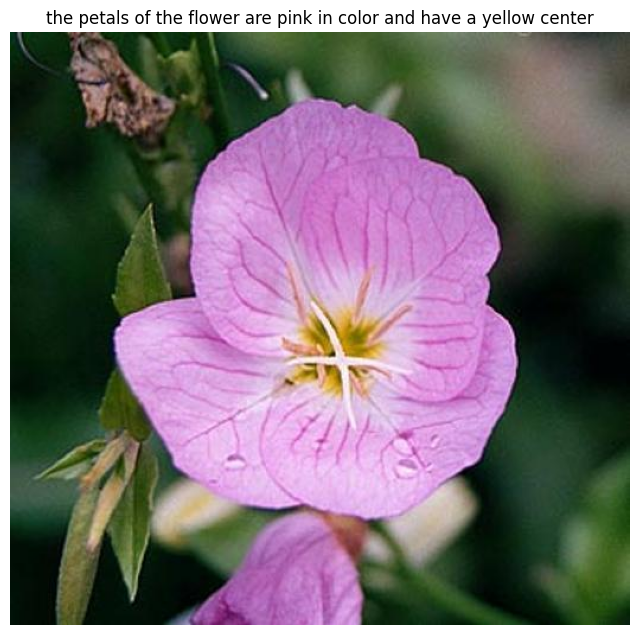

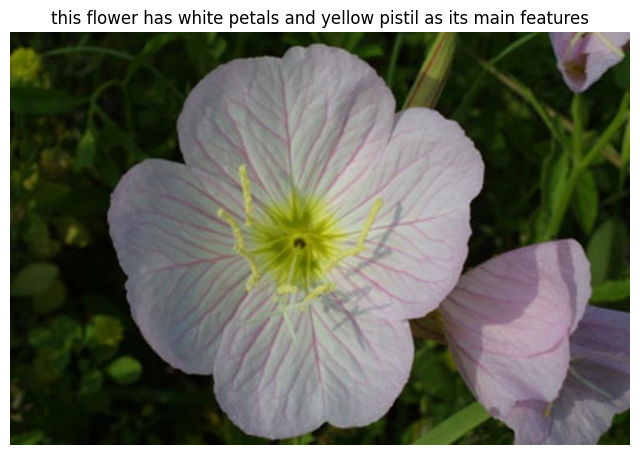

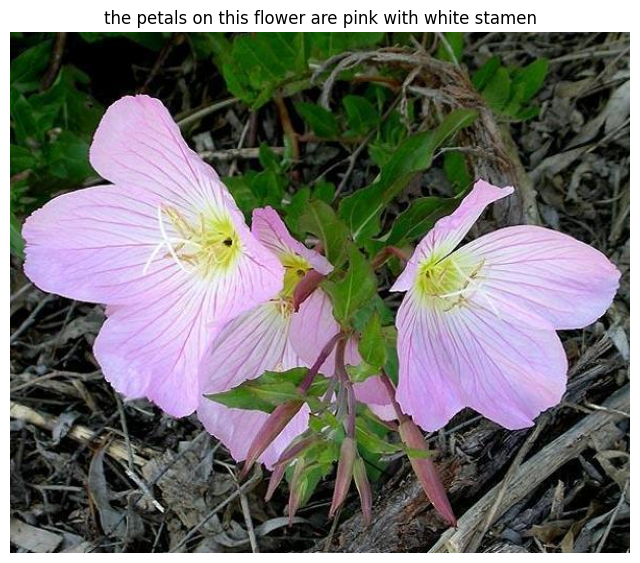

In [36]:
import matplotlib.pyplot as plt
import os

# Iterate over the first few rows to check
for row in train_data.head(3).itertuples():
    caption_ids = row.Captions[0] 
    text = ' '.join([id2word_dict[id] for id in caption_ids if id2word_dict[id] != '<PAD>'])
    
    image_path = row.ImagePath
    if os.path.exists(image_path):
        plt.figure(figsize=(8, 8))
        plt.imshow(plt.imread(image_path))
        plt.title(text)
        plt.axis('off')
        plt.show()
    else:
        print(f"Image not found: {image_path}")

=== Converting & Encoding Top 5 Captions ===
[1] the petals of the flower are pink in color and have a yellow center
[2] this flower has white petals and yellow pistil as its main features
[3] the petals on this flower are pink with white stamen
[4] the flower has a smooth purple petal with white pollen tubes and yellow anther
[5] this white flower has bright yellow stamen with large anther

Final Matrix Shape: (5, 768)

=== Cosine Similarity Matrix ===
[[1.0000002  0.7469407  0.78435606 0.74993676 0.62655103]
 [0.7469407  1.0000002  0.7342214  0.7489362  0.8395145 ]
 [0.78435606 0.7342214  0.9999999  0.71171916 0.73396116]
 [0.74993676 0.7489362  0.71171916 0.99999976 0.66746616]
 [0.62655103 0.8395145  0.73396116 0.66746616 0.9999999 ]]


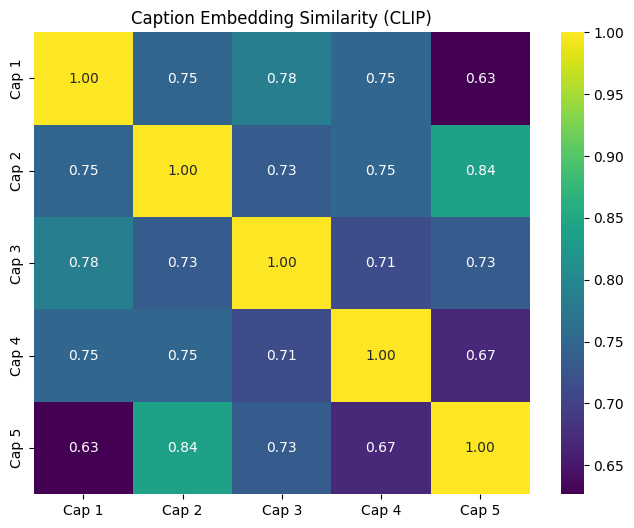

In [37]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# 存放結果的容器
collected_embeddings = []
collected_texts = []

print("=== Converting & Encoding Top 5 Captions ===")
train_data = pd.read_pickle('dataset/text2ImgData_withClipEmbeddings.pkl')

# 1. 迴圈處理前 5 筆
for i, row in enumerate(train_data.head(5).itertuples()):
    # --- A. 還原文字 ---
    # 取出第一句 ID 列表
    caption_ids = row.Captions[0] 
    # 轉回文字 (過濾 PAD)
    text = ' '.join([id2word_dict[id] for id in caption_ids if id2word_dict[id] != '<PAD>'])
    collected_texts.append(text)
    print(f"[{i+1}] {text}")
    
    # --- B. 即時計算 CLIP Embedding ---
    # 使用我們剛宣告的 tokenizer
    inputs = tokenizer(
        text, 
        return_tensors='tf', 
        max_length=32, 
        padding='max_length', 
        truncation=True
    )
    
    # 使用我們剛宣告的 text_encoder
    # 輸出形狀預期為 (1, 128)
    emb = text_encoder((inputs['input_ids'], inputs['attention_mask']))
    
    # 收集起來
    collected_embeddings.append(emb)

# 2. 合併成矩陣
# 將 list of tensors 堆疊成 (5, 128) 的 Tensor
embeddings_matrix = tf.concat(collected_embeddings, axis=0)
embeddings_np = embeddings_matrix.numpy()

print(f"\nFinal Matrix Shape: {embeddings_np.shape}") # 應該要是 (5, 128)

# 3. 計算相似度
sim_matrix = cosine_similarity(embeddings_np)

print("\n=== Cosine Similarity Matrix ===")
print(sim_matrix)

# 4. 視覺化
plt.figure(figsize=(8, 6))
sns.heatmap(sim_matrix, annot=True, fmt=".2f", cmap='viridis', 
            xticklabels=[f"Cap {i+1}" for i in range(5)], 
            yticklabels=[f"Cap {i+1}" for i in range(5)])
plt.title("Caption Embedding Similarity (CLIP)")
plt.show()